In [1]:
%matplotlib inline

import tensorflow as tf
from tensorflow import keras
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import mlab
import matplotlib
import pylab as pl
from scipy.fftpack import rfft
import aifc
from IPython.display import Image
from PIL import Image
from keras.callbacks import ModelCheckpoint
from matplotlib.backends.backend_pdf import PdfPages
from matplotlib.font_manager import FontProperties

Watch train data

In [2]:
df = pd.read_csv('../data/data/train.csv')
print(df.head(-5))

             clip_name  label
0          train1.aiff      0
1          train2.aiff      0
2          train3.aiff      0
3          train4.aiff      0
4          train5.aiff      0
...                ...    ...
29990  train29991.aiff      1
29991  train29992.aiff      1
29992  train29993.aiff      0
29993  train29994.aiff      0
29994  train29995.aiff      0

[29995 rows x 2 columns]


Let's try to plot a simple spectrogram

In [3]:
def PlotSpecgram(P, freqs, bins):
    """Spectrogram"""
    Z = np.flipud(P) # flip rows so that top goes to bottom, bottom to top, etc.
    xextent = 0, np.amax(bins)
    xmin, xmax = xextent
    extent = xmin, xmax, freqs[0], freqs[-1]

    im = pl.imshow(Z, extent=extent)
    pl.axis('auto')
    pl.xlim([0.0, bins[-1]])
    pl.ylim([0, 1000])

In [4]:
whale_sample_file = '../data/data/train/train1.aiff'
whale_aiff = aifc.open(whale_sample_file,'r')
print("Channels:", whale_aiff.getnchannels()) 
print("Frames:", whale_aiff.getnframes())
print("Frame rate (frames per second):", whale_aiff.getframerate())

Channels: 1
Frames: 4000
Frame rate (frames per second): 2000


/var/folders/xw/04yvk1hx1tg55kxcyvtbggcm0000gn/T/ipykernel_15081/726627918.py:2: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  whale_array = np.fromstring(whale_strSig, np.short).byteswap()


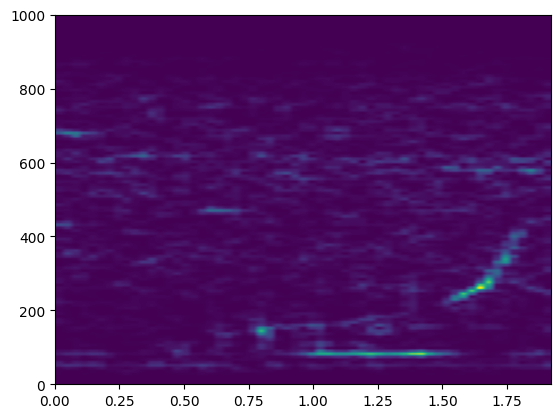

In [5]:
whale_strSig = whale_aiff.readframes(whale_aiff.getnframes())
whale_array = np.fromstring(whale_strSig, np.short).byteswap()
params = {'NFFT':256, 'Fs':2000, 'noverlap':192}
P, freqs, bins = mlab.specgram(whale_array, **params)
img = PlotSpecgram(P, freqs, bins)

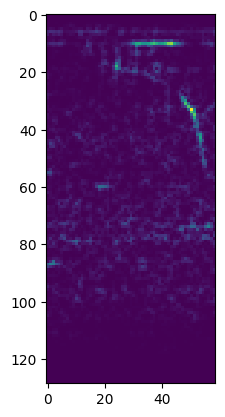

In [6]:
plt.imshow(P, interpolation='nearest')
plt.savefig("../images/data_ex", bbox_inches='tight')

In [7]:
# new_spect.shape

# new_spect *= 85.0/new_spect.max()

# Normalised [0,255] as integer: don't forget the parenthesis before astype(int)
# new_spect = (20.*(new_spect - np.min(new_spect))/np.ptp(new_spect))
# new_spect = 2.*(new_spect - np.min(new_spect))/np.ptp(new_spect)-1

# for i in range(len(new_spect)):
#     print(new_spect[i])

In [8]:
# img = np.zeros((129, 79, 3))
# img[:,:,0] = new_spect
# img[:,:,1] = new_spect
# img[:,:,2] = new_spect

# image = Image.fromarray(P, mode="L")
# # image.thumbnail((400, 400))
# image.save("test.jpg")
# print(image.mode)

Now we can plot and recognize others spectrograms and add a target for each of them

In [8]:
# Set path to directory with folders train and test
path_data = '../data/data/'
path_train_audio = '../data/data/train/'
path_target_train = '../data/data/train.csv'

In [9]:
# ReadAIFF function
def ReadAIFF(file):
# Reads the frames from the audio clip and returns the uncompressed data
    s = aifc.open(file,'r')
    nFrames = s.getnframes()
    strSig = s.readframes(nFrames)
    return np.fromstring(strSig, np.short).byteswap()

In [10]:
# Plot spectrogram function
def plot_spectrogram(filename, whale_flag):
# Plots a single spectrogram
    sound = ReadAIFF(filename)
    fig = plt.figure(figsize = (10,6), frameon=False)
    ax1 = fig.add_subplot(111)
    ax1.set_axis_off()
    # Setting spectrogram parameters
    my_cmap = matplotlib.cm.get_cmap('hsv_r')
    params = {'NFFT':256, 'Fs':2000, 'noverlap':192, 'cmap':my_cmap}
    plt.specgram(sound, **params)
    fig.savefig('test.png', bbox_inches='tight', pad_inches=0)
    # title0 = 'Spectrogram - Non-whale sound' if whale_flag == 0 else 'Spectrogram - Whale sound'
    # ax1.set_title(title0, fontsize = 16)
    # ax1.set_xlabel('Time (seconds)', fontsize = 12)
    # ax1.set_ylabel('Frequency (Hz)', fontsize = 12)
    # cbar = plt.colorbar()
    # cbar.set_label('Amplitude', fontsize = 12)

# # Plot non-whale sound    
# plot_spectrogram(path_data + 'train/train1.aiff', 0)
# Plot whale sound
# plot_spectrogram(path_data + 'train/train6.aiff', 1)

In [11]:
# Plot spectrograms side by side
def plot_sbs_spectrogram(filename_whale, filename_non_whale):
    whale = ReadAIFF(filename_whale)
    nonwhale = ReadAIFF(filename_non_whale)
    plt.figure(figsize = (14,4))
    ax1 = plt.subplot(121)
    my_cmap = matplotlib.cm.get_cmap('hsv_r')
    params = {'NFFT':256, 'Fs':2000, 'noverlap':192, 'cmap' : my_cmap}
    plt.specgram(whale, **params)
    ax1.set_title('Whale sound spectrogram', fontsize = 12)
    ax1.set_xlabel('Time (seconds)', fontsize = 12)
    ax1.set_ylabel('Frequency (Hz)', fontsize = 12)
    cbar = plt.colorbar()
    cbar.set_label('Amplitude', fontsize = 12)
    ax2 = plt.subplot(122)
    plt.specgram(nonwhale, **params)
    ax2.set_title('Non-whale sound spectrogram', fontsize = 12)
    ax2.set_xlabel('Time (seconds)', fontsize = 12)
    ax2.set_ylabel('Frequency (Hz)', fontsize = 12)
    cbar = plt.colorbar()
    cbar.set_label('Amplitude', fontsize = 12)
    plt.show()

# Compare several examples:
# plot_sbs_spectrogram(path_data + 'train/train6.aiff', path_data + 'train/train1.aiff')
# plot_sbs_spectrogram(path_data + 'train/train7.aiff', path_data + 'train/train2.aiff')
# plot_sbs_spectrogram(path_data + 'train/train9.aiff', path_data + 'train/train3.aiff')
# plot_sbs_spectrogram(path_data + 'train/train12.aiff', path_data + 'train/train4.aiff')

Create new data - from spectrograms to images

In [12]:
# # Set path to directory with folders train and test
# path_data = '../data/data/'
# path_train_audio = '../data/data/train/'
# path_train_img = '../data/data/train_img/'
# path_target_train = '../data/data/train.csv'

# def create_images_data(path_train_audio, path_train_img):
#     for i in range(len(df["clip_name"])):
#         whale_sample_file = path_train_audio + df["clip_name"][i]
#         sound = ReadAIFF(whale_sample_file)
#         fig = plt.figure(figsize = (10,6), frameon=False)
#         ax1 = fig.add_subplot(111)
#         ax1.set_axis_off()
#         # Setting spectrogram parameters
#         my_cmap = matplotlib.cm.get_cmap('hsv_r')
#         params = {'NFFT':256, 'Fs':2000, 'noverlap':192, 'cmap':my_cmap}
#         plt.specgram(sound, **params)
#         fig.savefig(path_train_img + df["clip_name"][i][:-5] + '.png', bbox_inches='tight', pad_inches=0)

# create_images_data(path_train_audio, path_train_img)

In [85]:
# Set path to directory with folders train and test
df = pd.read_csv('../data/data/train.csv')
path_train_img = '../datasets/pngs_from_wavs/'
path_train_img_noised_1 = '../datasets/pngs_from_wavs_noised_002/'

train_index = int(len(df["clip_name"]) * 0.8)
val_index = train_index + int(len(df["clip_name"]) * 0.1)
test_index = val_index + int(len(df["clip_name"]) * 0.1)

def create_dataset(train_index, val_index, test_index):

    x_train = []
    y_train = []

    x_val = []
    y_val = []
    
    x_test = []
    y_test = []
    for i in range(len(df["clip_name"])):
        # FILENAME = path_train_img + df["clip_name"][i][:-5] + '.png'
        FILENAME = path_train_img_noised_1 + df["clip_name"][i][:-5] + '.png'
        rgba_image = Image.open(FILENAME)
        img = rgba_image.convert('RGB')
        img_arr = np.asarray(img)
        rgba_image.close()
        #print(FILENAME)

        if i < train_index:
            x_train.append(img_arr)
            y_train.append(df["label"][i])
        elif i < val_index:
            x_val.append(img_arr)
            y_val.append(df["label"][i])
        else:
            x_test.append(img_arr)
            y_test.append(df["label"][i])
    return np.array(x_train), np.array(y_train), np.array(x_val), np.array(y_val), np.array(x_test), np.array(y_test)

In [86]:
x_train, y_train, x_val, y_val, x_test, y_test = create_dataset(train_index, val_index, test_index)

In [87]:
batch_size = 32

train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_data = train_data.cache().batch(batch_size).prefetch(buffer_size=100)

val_data = tf.data.Dataset.from_tensor_slices((x_val, y_val))
val_data = val_data.batch(batch_size).prefetch(buffer_size=100)

test_data = tf.data.Dataset.from_tensor_slices((x_test, y_test))
test_data = test_data.batch(batch_size).prefetch(buffer_size=100)

Create train dataset

- train : 80%
- val : 10%
- test : 10%

In [88]:
x_train.shape

(24000, 146, 139, 3)

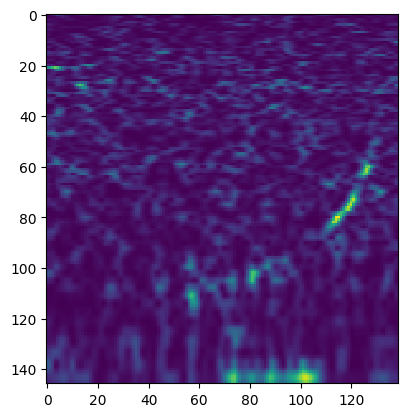

In [89]:
plt.imshow(x_train[0], interpolation='nearest')

Prepare data for NN

In [19]:
# size = (120, 120)

# train_ds = train_data.map(lambda x, y: (tf.image.resize(x, size), y))
# validation_ds = val_data.map(lambda x, y: (tf.image.resize(x, size), y))
# test_ds = test_data.map(lambda x, y: (tf.image.resize(x, size), y))

In [21]:
# import numpy as np

# for images, labels in train_ds.take(1):
#     plt.figure(figsize=(10, 10))
#     first_image = images[0]
#     plt.imshow(first_image.numpy().astype("int32"))
#     plt.title(int(labels[0]))
#     plt.axis("off")

In [45]:
import ssl

ssl._create_default_https_context = ssl._create_unverified_context

### Xception

In [63]:
# https://keras.io/guides/transfer_learning/

Xception_model = keras.applications.Xception(
    weights='imagenet',  # Load weights pre-trained on ImageNet.
    input_shape=(146, 139, 3),
    include_top=False)  # Do not include the ImageNet classifier at the top.

2023-03-14 12:16:04.400358: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


In [50]:
# Freeze the base_model
Xception_model.trainable = False

In [64]:
inputs = keras.Input(shape=(146, 139, 3))
x = inputs
# We make sure that the base_model is running in inference mode here,
# by passing `training=False`. This is important for fine-tuning, as you will
# learn in a few paragraphs.

# Pre-trained Xception weights requires that input be scaled
# from (0, 255) to a range of (-1., +1.), the rescaling layer
# outputs: `(inputs * scale) + offset`
scale_layer = keras.layers.Rescaling(scale=1 / 127.5, offset=-1)
x = scale_layer(x)

In [65]:
# The base model contains batchnorm layers. We want to keep them in inference mode
# when we unfreeze the base model for fine-tuning, so we make sure that the
# base_model is running in inference mode here.
x = Xception_model(x, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(0.2)(x)  # Regularize with dropout
x = keras.layers.Dense(200)(x)
outputs = keras.layers.Dense(1)(x)
model_x = keras.Model(inputs, outputs)

model_x.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 146, 139, 3)]     0         
                                                                 
 rescaling_2 (Rescaling)     (None, 146, 139, 3)       0         
                                                                 
 xception (Functional)       (None, 5, 5, 2048)        20861480  
                                                                 
 global_average_pooling2d_2   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_2 (Dropout)         (None, 2048)              0         
                                                                 
 dense_8 (Dense)             (None, 200)               409800    
                                                           

In [59]:
weights_file_x = '../weights_xception/xception_weights_1.h5'
model_x.load_weights(weights_file_x)

callback_x = ModelCheckpoint(weights_file_x, mode='max', save_best_only=True)

model_x.compile(
    optimizer=keras.optimizers.Adam(),
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[keras.metrics.BinaryAccuracy()],
)

epochs = 1
# history_x1 = model_x.fit(train_ds, epochs=epochs, validation_data=validation_ds, callbacks=[callback_x])
history_x1 = model_x.fit(train_data, epochs=epochs, validation_data=val_data, callbacks=[callback_x])

In [72]:
weights_file_x2 = '../weights_xception/xception_weights_2.h5'
callback_x2 = ModelCheckpoint(weights_file_x2, mode='max', save_best_only=True)
model_x.load_weights(weights_file_x2)

# Unfreeze the base_model. Note that it keeps running in inference mode
# since we passed `training=False` when calling it. This means that
# the batchnorm layers will not update their batch statistics.
# This prevents the batchnorm layers from undoing all the training
# we've done so far.
Xception_model.trainable = True


model_x.summary()

model_x.compile(
    optimizer=keras.optimizers.Adam(1e-5),  # Low learning rate
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[keras.metrics.BinaryAccuracy()],
)

# epochs = 1
# history_x2 = model_x.fit(train_data, epochs=epochs, validation_data=val_data, callbacks=[callback_x2])

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 146, 139, 3)]     0         
                                                                 
 rescaling_2 (Rescaling)     (None, 146, 139, 3)       0         
                                                                 
 xception (Functional)       (None, 5, 5, 2048)        20861480  
                                                                 
 global_average_pooling2d_2   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_2 (Dropout)         (None, 2048)              0         
                                                                 
 dense_8 (Dense)             (None, 200)               409800    
                                                           

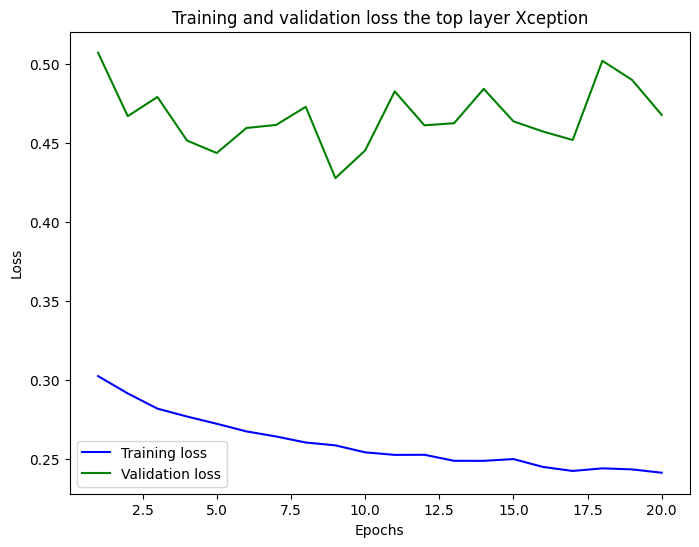

In [57]:
loss = history_x1.history['loss']
val_loss = history_x1.history['val_loss']
epochs = range(1, len(loss) + 1)
# plt.figure()
# plt.plot(epochs, loss, 'b', label='Training loss')
# plt.plot(epochs, val_loss, 'g', label='Validation loss')
# # plt.title('Training and validation loss')
# # plt.ylim(0, 0.3)
# plt.legend()
# plt.show()

pdf = PdfPages("../images/loss_x1.pdf")
fig, ax = plt.subplots(figsize=(8, 6))
# plt.figure(figsize=(8, 5))
# ax.axis('equal')
ax.plot(epochs, loss, 'b', label='Training loss')
ax.plot(epochs, val_loss, 'g', label='Validation loss')
plt.title('Training and validation loss the top layer Xception')
ax.set_ylabel("Loss")
ax.set_xlabel("Epochs")
plt.legend()
pdf.savefig(fig)
pdf.close()
plt.show()

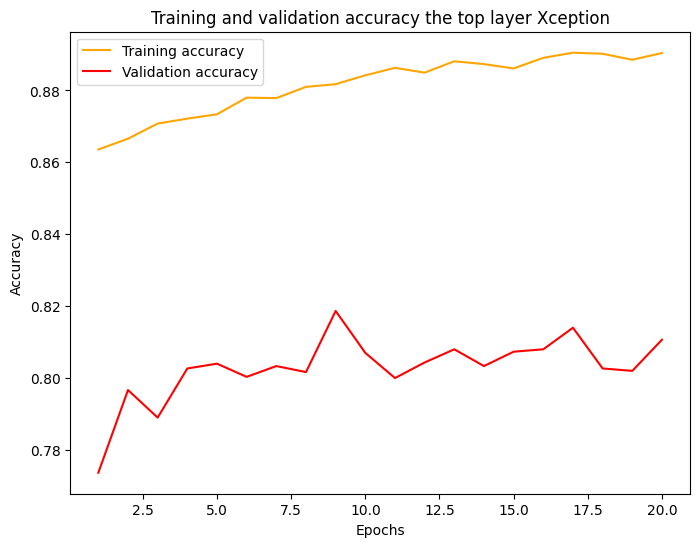

In [58]:
loss = history_x1.history['binary_accuracy']
val_loss = history_x1.history['val_binary_accuracy']
epochs = range(1, len(loss) + 1)
# plt.figure()
# plt.plot(epochs, loss, 'b', label='Training loss')
# plt.plot(epochs, val_loss, 'g', label='Validation loss')
# # plt.title('Training and validation loss')
# # plt.ylim(0, 0.3)
# plt.legend()
# plt.show()

pdf = PdfPages("../images/accuracy_x1.pdf")
fig, ax = plt.subplots(figsize=(8, 6))
# plt.figure(figsize=(8, 5))
# ax.axis('equal')
ax.plot(epochs, loss, color = 'orange', label='Training accuracy')
ax.plot(epochs, val_loss, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy the top layer Xception')
ax.set_ylabel("Accuracy")
ax.set_xlabel("Epochs")
plt.legend()
pdf.savefig(fig)
pdf.close()
plt.show()

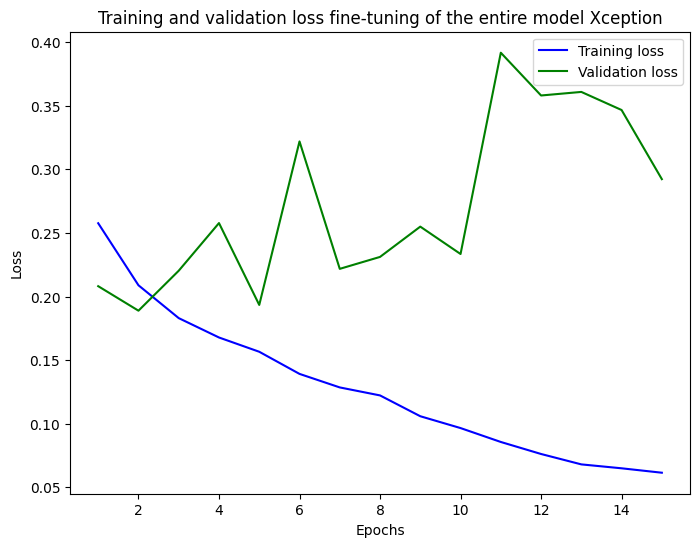

In [59]:
loss = history_x2.history['loss']
val_loss = history_x2.history['val_loss']
epochs = range(1, len(loss) + 1)
# plt.figure()
# plt.plot(epochs, loss, 'b', label='Training loss')
# plt.plot(epochs, val_loss, 'g', label='Validation loss')
# # plt.title('Training and validation loss')
# # plt.ylim(0, 0.3)
# plt.legend()
# plt.show()

pdf = PdfPages("../images/loss_x2.pdf")
fig, ax = plt.subplots(figsize=(8, 6))
# plt.figure(figsize=(8, 5))
# ax.axis('equal')
ax.plot(epochs, loss, 'b', label='Training loss')
ax.plot(epochs, val_loss, 'g', label='Validation loss')
plt.title('Training and validation loss fine-tuning of the entire model Xception')
ax.set_ylabel("Loss")
ax.set_xlabel("Epochs")
plt.legend()
pdf.savefig(fig)
pdf.close()
plt.show()

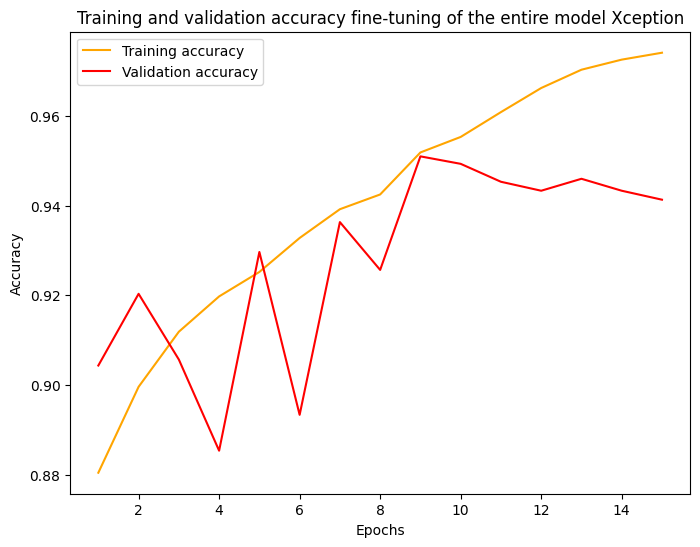

In [60]:
loss = history_x2.history['binary_accuracy']
val_loss = history_x2.history['val_binary_accuracy']
epochs = range(1, len(loss) + 1)
# plt.figure()
# plt.plot(epochs, loss, 'b', label='Training loss')
# plt.plot(epochs, val_loss, 'g', label='Validation loss')
# # plt.title('Training and validation loss')
# # plt.ylim(0, 0.3)
# plt.legend()
# plt.show()

pdf = PdfPages("../images/accuracy_x2.pdf")
fig, ax = plt.subplots(figsize=(8, 6))
# plt.figure(figsize=(8, 5))
# ax.axis('equal')
ax.plot(epochs, loss, color = 'orange', label='Training accuracy')
ax.plot(epochs, val_loss, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy fine-tuning of the entire model Xception')
ax.set_ylabel("Accuracy")
ax.set_xlabel("Epochs")
plt.legend()
pdf.savefig(fig)
pdf.close()
plt.show()

In [90]:
score_x = model_x.evaluate(test_data, verbose=0)
print("Xception test loss:", score_x[0])
print("Xception test accuracy:", score_x[1])

Xception test loss: 2.0428218841552734
Xception test accuracy: 0.8926666378974915


## New NN

In [213]:
# Set path to directory with folders train and test
df = pd.read_csv('../data/data/train.csv')
path_train_img = '../datasets/pngs_from_wavs/'

train_index = int(len(df["clip_name"]) * 0.8)
val_index = train_index + int(len(df["clip_name"]) * 0.1)
test_index = val_index + int(len(df["clip_name"]) * 0.1)

def create_dataset(train_index, val_index, test_index):

    x_train = []
    y_train = []

    x_val = []
    y_val = []
    
    x_test = []
    y_test = []
    for i in range(len(df["clip_name"])):
        FILENAME = path_train_img + df["clip_name"][i][:-5] + '.png'
        rgba_image = Image.open(FILENAME)
        img = rgba_image.convert('RGB')
        img_arr = np.asarray(img)
        rgba_image.close()
        #print(FILENAME)

        if i < train_index:
            x_train.append(img_arr)
            # if df["label"][i] == 1:
            #     y_train.append(100) # whale
            # else:
            #     y_train.append(-100) # not whale
            y_train.append(df["label"][i])
        elif i < val_index:
            x_val.append(img_arr)
            # if df["label"][i] == 1:
            #     y_val.append(100) # whale
            # else:
            #     y_val.append(-100) # not whale
            y_val.append(df["label"][i])
        else:
            x_test.append(img_arr)
            # if df["label"][i] == 1:
            #     y_test.append(100) # whale
            # else:
            #     y_test.append(-100) # not whale
            y_test.append(df["label"][i])
    return np.array(x_train), np.array(y_train), np.array(x_val), np.array(y_val), np.array(x_test), np.array(y_test)

In [214]:
batch_size = 32

x_train_img, y_train_img, x_val_img, y_val_img, x_test_img, y_test_img = create_dataset(train_index, val_index, test_index)

train_data = tf.data.Dataset.from_tensor_slices((x_train_img, y_train_img))
train_data = train_data.shuffle(120, reshuffle_each_iteration=True).batch(batch_size)

val_data = tf.data.Dataset.from_tensor_slices((x_val, y_val))
val_data = val_data.batch(batch_size)

test_data = tf.data.Dataset.from_tensor_slices((x_test_img, y_test_img))
test_data = test_data.batch(batch_size)

In [216]:
y_train_img.shape

(24000,)

In [97]:
# NEW FUNCTION FOR MAKING H/C TRAIN AND TEST FROM WAVS

from scipy.spatial.distance import jensenshannon
import librosa

def compute_spectral_info(spectrum):
    N = len(spectrum)
        
    H_p = 0
    H_q = 0
    Complexity_sq = 0
    Complexity_jen = 0
    Complexity_abs = 0
    
    yf = spectrum
        
    Sum = sum(yf) 
    square_sum = 0
    abs_sum = 0

    p_is = []
    for s in yf:
        
        p_i = s/Sum
        if (p_i > 0): 
            p_is.append(p_i)
            H_p += -p_i*np.log2(p_i)
        
    Nfft = len(p_is)
    q_i = 1.0/Nfft # Noise spectrum

    for k in range(Nfft):
        square_sum += (p_is[k] - q_i)**2
        abs_sum += np.abs(p_is[k] - q_i)

    Disequilibrium_sq = square_sum


    H_p /= np.log2(Nfft)

    Jensen = jensenshannon(p_is, [q_i for j in range(Nfft)])

    Q0 = -2.0/((Nfft+1)*np.log2(Nfft+1)/Nfft - 2*np.log2(2*Nfft)+np.log2(Nfft))
    
    Disequilibrium_jen = (Jensen**2)*Q0
    
    Complexity_sq = H_p*square_sum
    
    Complexity_jen = H_p*Disequilibrium_jen #H_p*square_sum#H_p*(Jensen**2)*Q0##H_p*square_sum##np.exp(H_p)*square_sum # H_p*(0.5*square_sum*len(p_is) - 1.0*third_sum*(len(p_is)**2)/6)# !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! 
    
    Complexity_abs += H_p*(abs_sum**2)/4

    return H_p, Complexity_sq, Complexity_jen, Complexity_abs

df = pd.read_csv('../data/data/train.csv')
path_train = '../datasets/train_wav/'

train_index = int(len(df["clip_name"]) * 0.8)
val_index = train_index + int(len(df["clip_name"]) * 0.1)
test_index = val_index + int(len(df["clip_name"]) * 0.1)

def create_HC_dataset_wavs(train_index, val_index, test_index):

    x_train = []
    y_train = []

    x_val = []
    y_val = []
    
    x_test = []
    y_test = []
    
    for i in range(len(df["clip_name"])):
        FILENAME = path_train + df["clip_name"][i][:-5] + '.wav'
        
        H_s = []
        C_sqs = []
        C_jsds = []
        
        y, sr = librosa.load(FILENAME, sr=None)
        WINDOW_FFT = 256
        WINDOW_HOP = 32

        D = librosa.stft(y, hop_length = WINDOW_HOP, n_fft = WINDOW_FFT, window = 'hamming')  # STFT of y
        # S_db = librosa.amplitude_to_db(np.abs(D), ref=np.max) #to decibels
        S_db = np.abs(D)
        for j in range(126):
            local_spect = S_db[:, j]
            H, C_sq, C_jsd, C_tv = compute_spectral_info(local_spect)
            H_s.append(H)
            C_sqs.append(C_sq)
            #C_jsds.append(C_jsd)
            
        hc_plane = ((H_s, C_sqs))
        #print(FILENAME)

        if i < train_index:
            x_train.append(hc_plane)
            y_train.append(df["label"][i])
        elif i < val_index:
            x_val.append(hc_plane)
            y_val.append(df["label"][i])
        else:
            x_test.append(hc_plane)
            y_test.append(df["label"][i])
    
    return np.array(x_train), np.array(y_train), np.array(x_val), np.array(y_val), np.array(x_test), np.array(y_test)

In [98]:
df = pd.read_csv('../data/data/train.csv')
path_train = '../datasets/train_wav/'

train_index = int(len(df["clip_name"]) * 0.8)
val_index = train_index + int(len(df["clip_name"]) * 0.1)
test_index = val_index + int(len(df["clip_name"]) * 0.1)

x_train_hc, y_train_hc, x_val_hc, y_val_hc, x_test_hc, y_test_hc = create_HC_dataset_wavs(train_index, val_index, test_index)

In [175]:
# def mean_data(data):
#     mean = data[:].mean(axis=0)
#     data -= mean
#     std = data[:].std(axis=0)
#     data /= std
#     return data

def avg_images(data):
    return data[:] / 255.0

In [100]:
x_train_hc.shape

(24000, 2, 126)

In [176]:
x_train_img = avg_images(x_train_img)
x_val_img = avg_images(x_val_img)
x_test_img = avg_images(x_test_img)

# x_train_hc = mean_data(x_train_hc)
# x_val_hc = mean_data(x_val_hc)
# x_test_hc = mean_data(x_test_hc)

In [150]:
train_data_hc = tf.data.Dataset.from_tensor_slices((x_train_hc, y_train_hc))
val_data_hc = tf.data.Dataset.from_tensor_slices((x_val_hc, y_val_hc))
test_data_hc = tf.data.Dataset.from_tensor_slices((x_test_hc, y_test_hc))

batch_size = 32

train_data_hc = train_data_hc.batch(batch_size)
val_data_hc = val_data_hc.batch(batch_size)
test_data_hc = test_data_hc.batch(batch_size)

In [27]:
x_train_img.shape

(24000, 146, 139, 3)

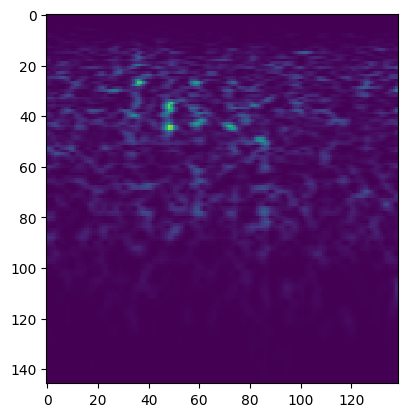

In [30]:
plt.imshow(x_train_img[10], interpolation='nearest')

In [31]:
from keras.layers import Dense, Conv2D, Flatten, ConvLSTM2D, Input, Rescaling, LSTM, Concatenate, Dropout
from keras import Sequential

In [38]:
# cnn
image_input = Input(shape=(146, 139, 3))
image_out = Conv2D(128, kernel_size=3, activation='relu')(image_input)
image_out = Dropout(0.1)(image_out)
image_out = Conv2D(32, kernel_size=3, activation='relu')(image_out)
image_out = Dropout(0.1)(image_out)
image_out = Flatten()(image_out)
image_output = Dense(10, activation='relu')(image_out)

# rnn
series_input = Input(shape=x_train_hc.shape[-2:])
series_out = LSTM(20)(series_input)
series_out = Dense(128, activation='relu')(series_out)
series_out = Dropout(0.1)(series_out)
series_output = Dense(10, activation='relu')(series_out)

# final nn
concat = Concatenate()([image_output, series_output])
out = Dense(32, activation='relu')(concat)
out = Dropout(0.1)(out)
out = Dense(16, activation='relu')(out)
output = Dense(1, activation='softmax')(out)

model = tf.keras.Model([image_input, series_input], output)

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 146, 139, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_5 (Conv2D)              (None, 144, 137, 12  3584        ['input_3[0][0]']                
                                8)                                                                
                                                                                                  
 dropout_4 (Dropout)            (None, 144, 137, 12  0           ['conv2d_5[0][0]']               
                                8)                                                          

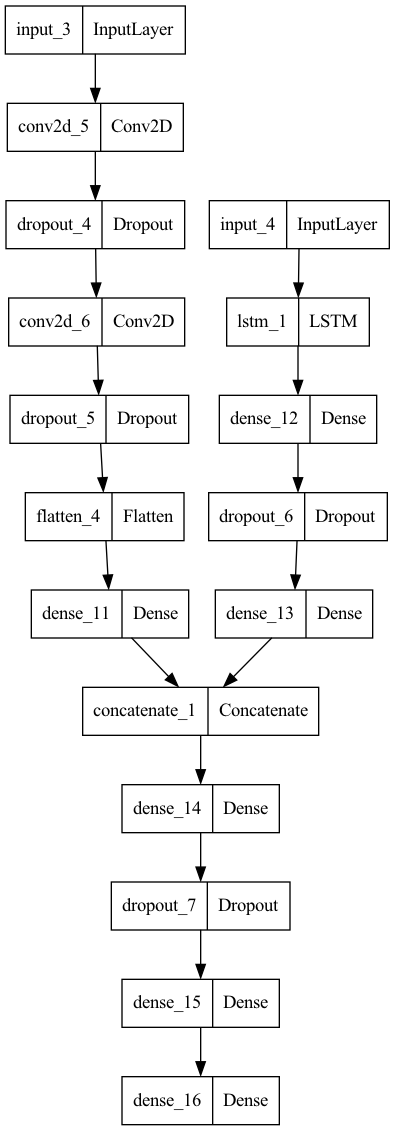

In [39]:
from tensorflow.keras.utils import plot_model

model.compile(optimizer='adam',
            loss='binary_crossentropy',
            metrics=['binary_accuracy'])

model.summary()

plot_model(model, to_file="model.png")

In [40]:
history = model.fit(x=[x_train_img, x_train_hc], y=y_train_img,
    validation_data=([x_val_img, x_val_hc], y_val_img),
    epochs=10, batch_size=32)

Epoch 1/10
750/750 [==============================] - 500s 664ms/step - loss: 0.3963 - binary_accuracy: 0.2226 - val_loss: 0.6560 - val_binary_accuracy: 0.4500
Epoch 2/10
750/750 [==============================] - 491s 655ms/step - loss: 0.3445 - binary_accuracy: 0.2226 - val_loss: 0.4153 - val_binary_accuracy: 0.4500
Epoch 3/10
750/750 [==============================] - 490s 653ms/step - loss: 0.3276 - binary_accuracy: 0.2226 - val_loss: 0.4247 - val_binary_accuracy: 0.4500
Epoch 4/10
750/750 [==============================] - 488s 650ms/step - loss: 0.3200 - binary_accuracy: 0.2226 - val_loss: 0.4166 - val_binary_accuracy: 0.4500
Epoch 5/10
750/750 [==============================] - 488s 650ms/step - loss: 0.3048 - binary_accuracy: 0.2226 - val_loss: 0.3684 - val_binary_accuracy: 0.4500
Epoch 6/10
750/750 [==============================] - 488s 651ms/step - loss: 0.2968 - binary_accuracy: 0.2226 - val_loss: 0.4523 - val_binary_accuracy: 0.4500
Epoch 7/10
750/750 [====================

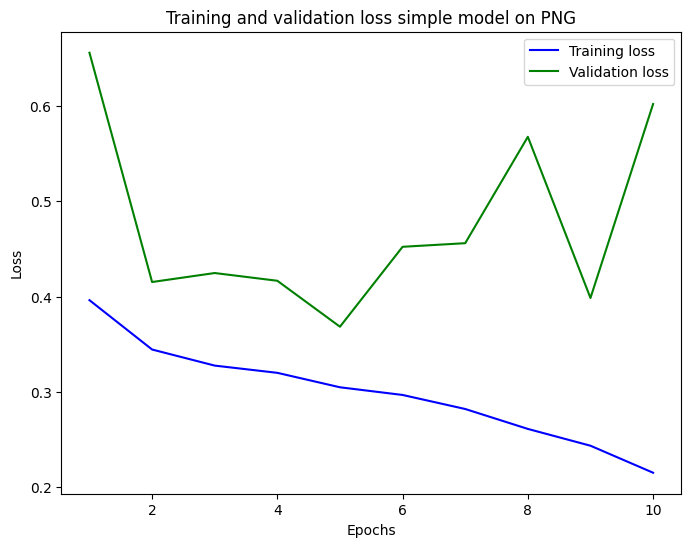

In [41]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)

# pdf = PdfPages("../images/loss_simple_png.pdf")
fig, ax = plt.subplots(figsize=(8, 6))
# plt.figure(figsize=(8, 5))
# ax.axis('equal')
ax.plot(epochs, loss, 'b', label='Training loss')
ax.plot(epochs, val_loss, 'g', label='Validation loss')
plt.title('Training and validation loss simple model on PNG')
ax.set_ylabel("Loss")
ax.set_xlabel("Epochs")
plt.legend()
# pdf.savefig(fig)
# pdf.close()
plt.show()

In [42]:
score = model.evaluate([x_test_img, x_test_hc], y_test_img)
print("Simple CNN test loss:", score[0])
print("Simple CNN test accuracy:", score[1])

94/94 [==============================] - 12s 127ms/step - loss: 0.2166 - binary_accuracy: 0.1113
Simple CNN test loss: 0.2165912538766861
Simple CNN test accuracy: 0.11133333295583725


In [38]:
train_data_img = tf.data.Dataset.from_tensor_slices((x_train_img, y_train_img))
val_data_img = tf.data.Dataset.from_tensor_slices((x_val_img, y_val_img))
test_data_img = tf.data.Dataset.from_tensor_slices((x_test_img, y_test_img))

batch_size = 32

train_ds = train_data_img.cache().batch(batch_size).prefetch(buffer_size=100)
validation_ds = val_data_img.batch(batch_size).prefetch(buffer_size=100)
test_ds = test_data_img.batch(batch_size).prefetch(buffer_size=100)

In [44]:
# import numpy as np

# for images, labels in train_data_img.take(1):
#     plt.figure(figsize=(10, 10))
#     first_image = images
#     plt.imshow(first_image.numpy().astype("float64"))
#     plt.title(int(labels))
#     plt.axis("off")

In [218]:
#create model
model_png = Sequential()
#add model layers
model_png.add(Conv2D(64, kernel_size=3, activation='tanh', input_shape=(146, 139, 3)))
# model_png.add(Conv2D(32, kernel_size=3, activation='relu'))
# model.add(ConvLSTM2D(24, kernel_size=3))
model_png.add(Flatten())
model_png.add(Dense(50, activation='tanh'))
model_png.add(Dense(1, activation='softmax'))

#compile model using accuracy to measure model performance
model_png.compile(optimizer=keras.optimizers.Adam(),
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[keras.metrics.BinaryAccuracy()])

#train the model
history_png = model_png.fit(train_data, validation_data=val_data, epochs=5)

Epoch 1/5
354/750 [=============>................] - ETA: 40s - loss: -705.2121 - binary_accuracy: 0.0000e+00

KeyboardInterrupt: 

In [36]:
score = model_png.evaluate(test_data)
print("Simple CNN test loss:", score[0])
print("Simple CNN test accuracy:", score[1])

94/94 [==============================] - 1s 13ms/step - loss: 0.4280 - binary_accuracy: 0.1113
Simple CNN test loss: 0.4280204772949219
Simple CNN test accuracy: 0.11133333295583725


In [195]:
# rnn
model_hc = Sequential()
model_hc.add(LSTM(10, input_shape=x_train_hc.shape[-2:]))
model_hc.add(Dense(5, kernel_initializer='random_normal', activation='relu'))
model_hc.add(Dense(3, kernel_initializer='random_normal', activation='relu'))
model_hc.add(Dense(2, kernel_initializer='random_normal', activation='softmax'))

#compile model using accuracy to measure model performance
model_hc.compile(optimizer=keras.optimizers.Adam(),
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[keras.metrics.BinaryAccuracy()])

#train the model
history_hc = model_hc.fit(train_data_hc, validation_data=val_data_hc, epochs=1)

750/750 [==============================] - 2s 1ms/step - loss: 0.5951 - binary_accuracy: 0.7766 - val_loss: 0.7409 - val_binary_accuracy: 0.5500


In [200]:
from keras import backend as K

inp = model_hc.input                                           # input placeholder
outputs = [layer.output for layer in model_hc.layers]          # all layer outputs
functors = [K.function([inp], [out]) for out in outputs]    # evaluation functions

# Testing
input_shape=x_train_hc.shape[-2:]
test = np.random.random(input_shape)[np.newaxis,...]
layer_outs = [func([test]) for func in functors]
print(layer_outs)

[[array([[-0.9629658 ,  0.96298385, -0.96347195,  0.9636778 , -0.96322596,
         0.9629503 ,  0.9634506 ,  0.9633366 ,  0.9635843 ,  0.95850503]],
      dtype=float32)], [array([[0.9877598 , 0.9910485 , 0.9907734 , 0.9897851 , 0.98732495]],
      dtype=float32)], [array([[0.9784226]], dtype=float32)], [array([[0.2958442]], dtype=float32)]]


In [199]:
score = model_hc.evaluate(test_data_hc)
print("Simple rnn test loss:", score[0])
print("Simple rnn test accuracy:", score[1])

94/94 [==============================] - 0s 576us/step - loss: 0.4474 - binary_accuracy: 0.8887
Simple rnn test loss: 0.4473848044872284
Simple rnn test accuracy: 0.8886666893959045


In [161]:
zero = 0
one = 0

for i in y_test_hc:
    if i == 0:
        zero += 1
    else:
        one += 1

print(zero, one)

2666 334
